In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.fft import fft, ifft

In [13]:
    dt = 1; N = 1000; q = 0.01; X1 = 9.0
A1 = 1; nu1 = 0.1; phi1 = 0
gamma = 0.50; alpha = 0.1; beta = 0.05

In [9]:
def sigma_n(A1, gamma):
    return(np.sqrt(A1**2/2/gamma))

def eps(N):
    return(norm.rvs(size=N))
           
def makeData(alpha, beta, A1, nu1, phi1, gamma, N, dt):
    t=[dt*k for k in range(N)]
    x=[alpha+beta*t[k]+A1*np.cos(2*np.pi*nu1*t[k]-phi1)+sigma_n(A1, gamma)*eps(N)[k] for k in range(0,N)]
    return([t,x])

# Uniform time series

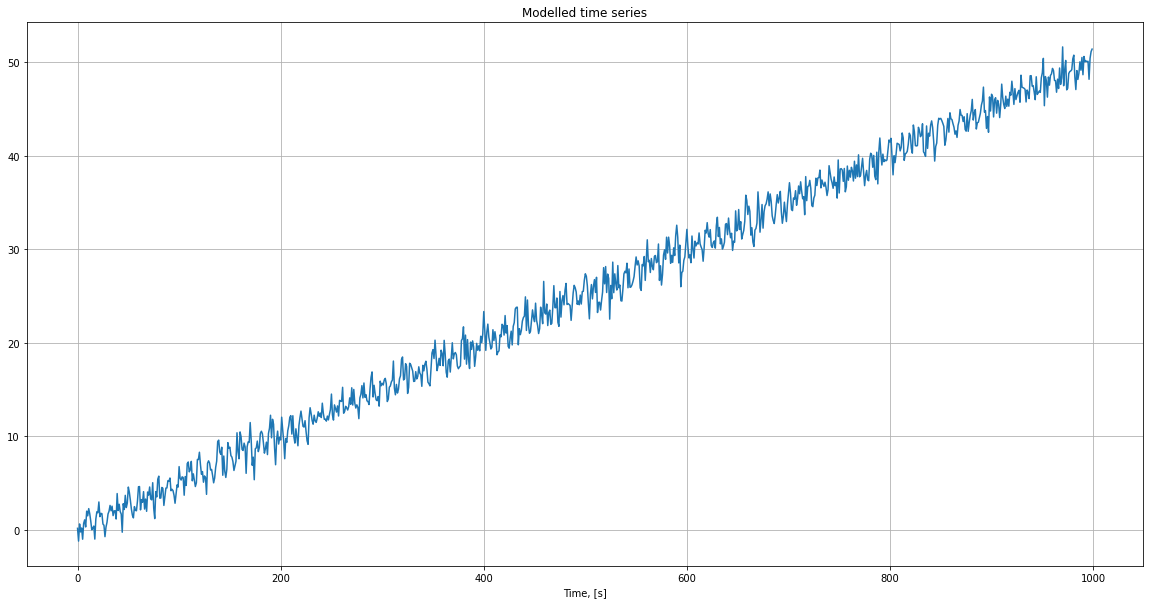

In [14]:
data = makeData(alpha, beta, A1, nu1, phi1, gamma, N, dt)

fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(data[0], data[1])
ax.grid()
ax.set_xlabel('Time, [s]')
ax.set_title('Modelled time series')
plt.savefig('ModelledTimeSeries.pdf')
plt.show()

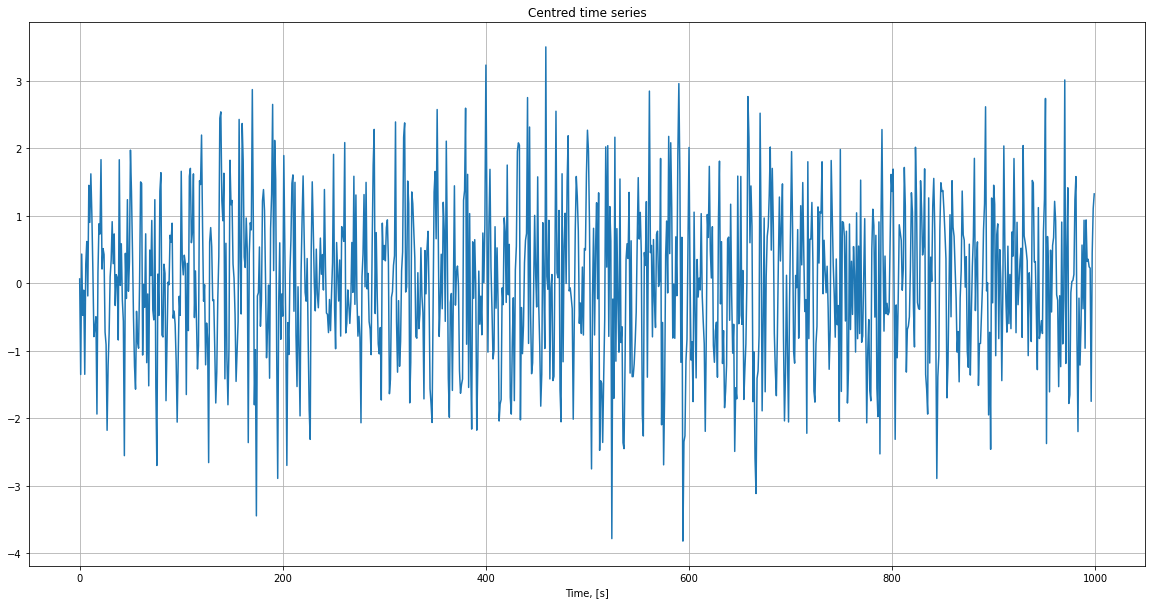

In [15]:
fp, residuals, rank, sv, rcond = np.polyfit(data[0], data[1], 1, full=True)
trend = np.poly1d(fp)

def centred_data(data, trend):
    return(data[1]-trend(data[0]))

fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(data[0], centred_data(data, trend))
ax.grid()
ax.set_xlabel('Time, [s]')
ax.set_title('Centred time series')
plt.savefig('CentredTimeSeries.pdf')
plt.show()

# Schuster periodogram

0.012218064600620014


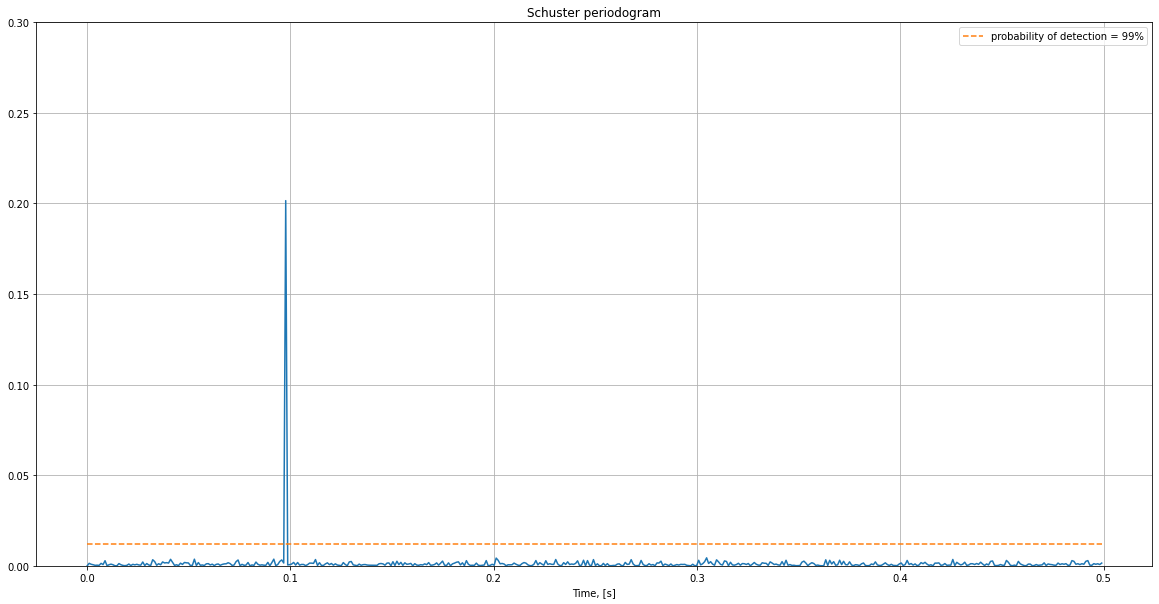

In [16]:
N1 = 512; N2 = 1024

def DFun(data,N):
    return(1/N**2*(data.real**2+data.imag**2))

def dnu(N2, dt):
    return(1/N2/dt)
supp_data = centred_data(data, trend)
for i in range(N,N2-N): supp_data = np.append(supp_data,0)
fft_data = np.fft.fft(supp_data)
D = DFun(fft_data,N)
nu = np.array([dnu(N2,dt)*j for j in range(N1)])
#var = np.var(supp_data)
var = 1/(N-1)*np.sum(supp_data**2)
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(nu, D[:N1])
ax.plot([nu[0], nu[N1-1]],[var*X1/N,var*X1/N], linestyle='--', label = r'probability of detection = 99%')
print(var*X1/N)
ax.grid()
ax.set_ylim(0,0.3)
ax.set_xlabel('Time, [s]')
ax.set_title('Schuster periodogram')
ax.legend()
plt.savefig('Schuster.pdf')
plt.show()

In [193]:
N_star = int(0.5*N)
a = 0.25

def cFun(data, N, N_star, a):
    c0 = np.fft.ifft(abs(data)**2).real/N
    W = np.array([1 - 2*a + 2*a*np.cos(np.pi*m/N_star) for m in range(N_star)])
    return([c0,c0[:N_star]*W])

c = cFun(fft_data, N, N_star, a)
supp_c = c[1]

for i in range(N_star, N2-N_star): supp_c = np.append(supp_c,0)
def D2Fun(c, N_star):
    tmp = 2*np.fft.fft(c).real
    D2 = (tmp - c[0])/N_star
    return(D2)
D2 = D2Fun(supp_c, N_star)

In [203]:
N_star_2 = int(0.1*N)
c_2 = cFun(fft_data, N, N_star_2, a)
supp_c_2 = c_2[1]
for i in range(N_star_2, N2-N_star_2): supp_c_2 = np.append(supp_c_2,0)
D2_2 = D2Fun(supp_c_2, N_star_2)

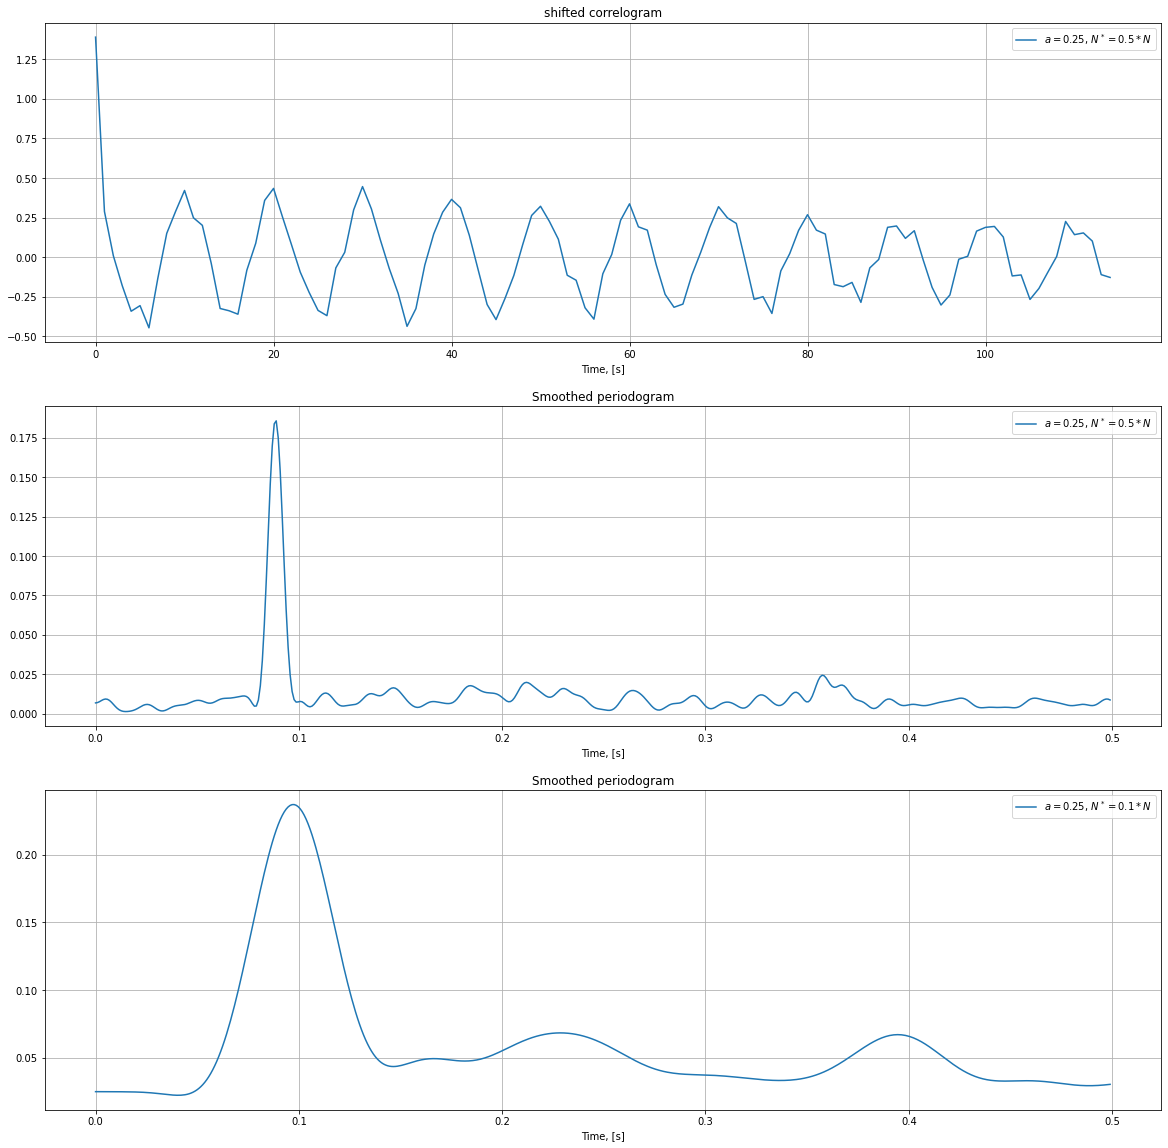

In [215]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,20))
ax1.plot(t[:N_star], c[0][:N_star], label = r'$a = 0.25$, $N^* = 0.5*N$')
ax1.grid()
ax1.set_xlabel('Time, [s]')
ax1.set_title('shifted correlogram')
ax1.legend()

ax2.plot(nu, D2[:N1], label = r'$a = 0.25$, $N^* = 0.5*N$')
ax2.grid()
ax2.set_xlabel('Time, [s]')
ax2.set_title('Smoothed periodogram')
ax2.legend()

ax3.plot(nu, D2_2[:N1], label = r'$a = 0.25$, $N^* = 0.1*N$')
ax3.grid()
ax3.set_xlabel('Time, [s]')
ax3.set_title('Smoothed periodogram')
ax3.legend()
plt.savefig('CorellogramPeriodograms.pdf')
plt.show()